## Hatched map plot showing correlation (Pearson's p and r values) between SM-LG and Ku-band interpolated freeboard smoothed anomalies for 2019-2020 season
hatched correlated map for CS2_S3_CPOM, CS2_Bristol, CS2_CPOM, CS2_S3_Bristol

In [1]:
import numpy as np
from scipy.stats import pearsonr
import datetime
import pandas as pd
from scipy.stats import linregress
from netCDF4 import Dataset
from scipy.interpolate import griddata
import os
import pickle
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy
import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
days = np.arange(0,4018)
dates = [datetime.date(2010,1,1)+datetime.timedelta(days=np.int(days)) for days in days]

# import snow data
snow = np.load('/Users/carmennab/PhD/OI_PolarSnow/SnowModelLG/SM_snod_combined_regridded.npy')

# load Will's grid, 160 x 160 array
x_WG = np.load('/Users/carmennab/PhD/OI_PolarSnow/SnowModelLG/new_x_WG.npy') 
y_WG = np.load('/Users/carmennab/PhD/OI_PolarSnow/SnowModelLG/new_y_WG.npy')

# import freeboard data
sats = ['CS2_CPOM','CS2_Bristol','CS2_S3_CPOM','CS2_S3_Bristol']
datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_interpolated/'
folders = ['CS2_CPOM/','Bristol_LARM/CS2/freeboard/','CS2_S3_GPOD/MERGE/','GPOD_Bristol/MERGE/']

CS2_CPOM = np.full((len(days),160,160), np.nan)
CS2_LARM = np.full((len(days),160,160), np.nan)
CS2S3_CPOM = np.full((len(days),160,160), np.nan)
CS2S3_LARM = np.full((len(days),160,160), np.nan)
dics = [CS2_CPOM,CS2_LARM,CS2S3_CPOM,CS2S3_LARM]

for sat, folder, dic in zip (sats,folders, dics):
    location = datapath + folder
    for day in tqdm.tqdm(days):
        date = dates[day].strftime('%Y%m%d')
        for f in os.listdir(location):
            if 'FB_interp' in f:
                if date in f:
                    dic[day] = np.load(location+str(f)) 
                else: 
                    pass

100%|█████████████████████████████████████| 4018/4018 [00:01<00:00, 2158.06it/s]


CS2_CPOM


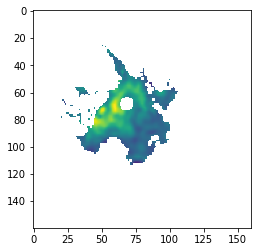

CS2_Bristol


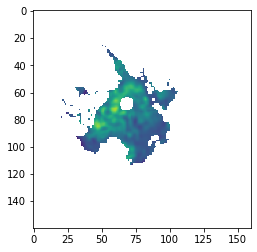

CS2_S3_CPOM


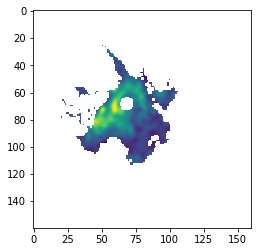

CS2_S3_Bristol


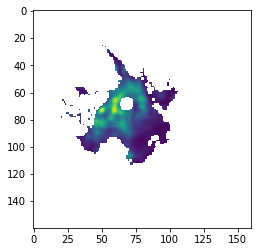

In [3]:
for sat, dic in zip(sats,dics):
    print(sat)
    plt.imshow(dic[3600])
    plt.show()

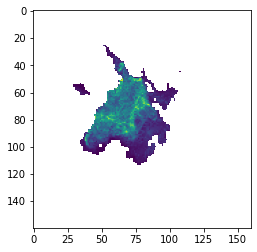

In [4]:
plt.imshow(snow[3600])

# plot all seasons in one

In [5]:
# do smooth anoms for each grid cell

T1 = 15 ## for 30-day running mean put T=15
T2 = 4 ## for 9-day running mean of anomalies put T=4

CS2S3_CPOM_anoms_big = np.full(snow.shape,np.nan)
CS2_LARM_anoms_big = np.full(snow.shape,np.nan)
CS2_CPOM_anoms_big = np.full(snow.shape,np.nan)
CS2S3_LARM_anoms_big = np.full(snow.shape,np.nan)
snows_anoms_big = np.full(snow.shape,np.nan)

for day in tqdm.trange(snow.shape[0]):
    
    # each day, make the 30 day running mean (15 either side)
    
    snows_30day = np.nanmean(snow[day-T1:day+T1],axis=0) # 30-day running mean for each grid cell in time dimension
    CS2S3_CPOM_30day = np.nanmean(CS2S3_CPOM[day-T1:day+T1],axis=0)
    CS2_LARM_30day = np.nanmean(CS2_LARM[day-T1:day+T1],axis=0)
    CS2_CPOM_30day = np.nanmean(CS2_CPOM[day-T1:day+T1],axis=0)
    CS2S3_LARM_30day = np.nanmean(CS2S3_LARM[day-T1:day+T1],axis=0)
    
    # now make anomalies from 30 day means
    
    snows_anoms_big[day] = snow[day] - snows_30day 
    CS2S3_CPOM_anoms_big[day] = CS2S3_CPOM[day] - CS2S3_CPOM_30day
    CS2_LARM_anoms_big[day] = CS2_LARM[day] - CS2_LARM_30day
    CS2_CPOM_anoms_big[day] = CS2_CPOM[day] - CS2_CPOM_30day
    CS2S3_LARM_anoms_big[day] = CS2S3_LARM[day] - CS2S3_LARM_30day
    

# the following for loop can actually be removed by taking the running mean with convolve
# RDCM has done this before, you have to convolve along an axis of a 3d numpy array using a special module

CS2S3_CPOM_running_mean_anoms = np.full(snow.shape,np.nan)
CS2_LARM_running_mean_anoms = np.full(snow.shape,np.nan)
CS2_CPOM_running_mean_anoms = np.full(snow.shape,np.nan)
CS2S3_LARM_running_mean_anoms = np.full(snow.shape,np.nan)
sd_running_mean_anoms = np.full(snow.shape,np.nan)

# 9 day mean of anoms for each grid cell in time dimension
for day in tqdm.trange(snow.shape[0]):
        CS2_LARM_running_mean_anoms[day] = np.nanmean(CS2_LARM_anoms_big[day-T2:day+T2],axis=0) 
        CS2_CPOM_running_mean_anoms[day] = np.nanmean(CS2_CPOM_anoms_big[day-T2:day+T2],axis=0)
        CS2S3_CPOM_running_mean_anoms[day] = np.nanmean(CS2S3_CPOM_anoms_big[day-T2:day+T2],axis=0) 
        CS2S3_LARM_running_mean_anoms[day] = np.nanmean(CS2S3_LARM_anoms_big[day-T2:day+T2],axis=0) 
        sd_running_mean_anoms[day] = np.nanmean(snows_anoms_big[day-T2:day+T2],axis=0)

100%|██████████████████████████████████████| 4018/4018 [00:13<00:00, 293.12it/s]


In [6]:
# stats for CS2 full 2010-2020 period
sats = ['CS2_CPOM_full','CS2_LARM_full']
dics = [CS2_CPOM_running_mean_anoms,CS2_LARM_running_mean_anoms]

all_ps = {}
all_rs = {}
all_rs_list = {}

for sat, dic in zip(sats,dics):
    rs_list = []

    ps = np.full((160,160), np.nan)
    rs = np.full((160,160), np.nan)
    #n_valid = np.full((160,160), np.nan)

    for i, j in tqdm.tqdm(itertools.product(np.arange(160),
                                  np.arange(160))):
        # calculate p and r for full timeseries per grid cell

        mask = ~np.isnan(dic[:,i,j]) & ~np.isnan(sd_running_mean_anoms[:,i,j]) # mask out cells with nan snow or nan freeb

        if np.count_nonzero(np.nan_to_num(mask)) > 2: # if more than 2 days in snow and freeb have data then continue


            rstats = pearsonr(dic[:,i,j][mask],sd_running_mean_anoms[:,i,j][mask]) # correlate valid snow and freeb for each grid cell 
            r = np.round(rstats[0],decimals=2)
            p = np.round(rstats[1],decimals=3)
            ps[i,j] = p
            rs[i,j] = r
            if p < 0.05:
                rs_list.append(r)
            #n_valid[i,j] = len(mask[mask]) # number of valid days in time series - where mask is true 
    all_ps[sat] = ps
    all_rs[sat] = rs
    all_rs_list[sat] = rs_list

25600it [00:03, 7891.49it/s] 
25600it [00:03, 8342.74it/s] 


In [7]:
# stats for 2019-2020 only
sats = ['CS2_CPOM','CS2_LARM','CS2S3_CPOM','CS2S3_LARM']
dics = [CS2_CPOM_running_mean_anoms,CS2_LARM_running_mean_anoms,CS2S3_CPOM_running_mean_anoms,CS2S3_LARM_running_mean_anoms]

for sat, dic in zip(sats,dics):
    rs_list = []
    
    fb = dic[3560:3773]
    snow = sd_running_mean_anoms[3560:3773]

    ps = np.full((160,160), np.nan)
    rs = np.full((160,160), np.nan)
    #n_valid = np.full((160,160), np.nan)

    for i, j in tqdm.tqdm(itertools.product(np.arange(160),
                                  np.arange(160))):
        # calculate p and r for full timeseries per grid cell

        mask = ~np.isnan(fb[:,i,j]) & ~np.isnan(snow[:,i,j]) # mask out cells with nan snow or nan freeb

        if np.count_nonzero(np.nan_to_num(mask)) > 2: # if more than 2 days in snow and freeb have data then continue


            rstats = pearsonr(fb[:,i,j][mask],snow[:,i,j][mask]) # correlate valid snow and freeb for each grid cell 
            r = np.round(rstats[0],decimals=2)
            p = np.round(rstats[1],decimals=3)
            ps[i,j] = p
            rs[i,j] = r
            if p < 0.05:
                rs_list.append(r)
            #n_valid[i,j] = len(mask[mask]) # number of valid days in time series - where mask is true 
    all_ps[sat] = ps
    all_rs[sat] = rs
    all_rs_list[sat] = rs_list

25600it [00:00, 43677.14it/s]
25600it [00:00, 42734.19it/s]
25600it [00:00, 44264.23it/s]
25600it [00:00, 45085.18it/s]


In [8]:
CS2_diff = np.abs(np.asarray(all_rs['CS2_CPOM_full'])) - np.abs(np.asarray(all_rs['CS2_LARM_full']))
all_rs['CS2_CPOM_full - CS2_LARM_full'] = CS2_diff
all_ps['CS2_CPOM_full - CS2_LARM_full'] = np.full((160,160), 0.04)
CS2_diff = np.abs(np.asarray(all_rs['CS2_CPOM'])) - np.abs(np.asarray(all_rs['CS2_LARM']))
all_rs['CS2_CPOM - CS2_LARM'] = CS2_diff
all_ps['CS2_CPOM - CS2_LARM'] = np.full((160,160), 0.04)
CS2S3_diff = np.abs(np.asarray(all_rs['CS2S3_CPOM'])) - np.abs(np.asarray(all_rs['CS2S3_LARM']))
all_rs['CS2S3_CPOM - CS2S3_LARM'] = CS2S3_diff
all_ps['CS2S3_CPOM - CS2S3_LARM'] = np.full((160,160), 0.04)

In [9]:
dayss = [np.arange(273,485), # 2010-2011
        np.arange(638,851), # 2011-2012
        np.arange(1004,1216), # 2012-2013
        np.arange(1369,1581), # 2013-2014
        np.arange(1734,1946), # 2014-2015
        np.arange(2099,2312), # 2015-2016
        np.arange(2465,2677), # 2016-2017
        np.arange(2830,3042), # 2017-2018
        np.arange(3195,3407), # 2018-2019
        np.arange(3560,3773), # 2019-2020
       ]

all_MYI = []
datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/icetype/'

days = np.arange(0,4018)
dates = [datetime.date(2010,1,1)+datetime.timedelta(days=np.int(days)) for days in days]

all_MYI=np.full((4018,1120, 760),np.nan)

for day in days:#key is a date, so looping through each day for which we have gridded CS2 obs in this season
    date = dates[day].strftime('%Y%m%d')
    try:
        icetype = Dataset(datapath+'ice_type_nh_polstere-100_multi_'+str(date)+'1200.nc')
        ice_type = np.asarray(icetype['ice_type'][0])
        ice_type[ice_type>3]=0
        ice_type[ice_type<3]=0
        ice_type[ice_type==3]=1
        all_MYI[day] = ice_type
    except:
        pass
    
MYI_days = (all_MYI == 1).sum(axis = 0).astype(np.float32)    
icetype_lon = np.array(icetype['lon'])
icetype_lat = np.array(icetype['lat'])
total = len(dayss[0])+len(dayss[1])+len(dayss[2])+len(dayss[3])+len(dayss[4])+len(dayss[5])+len(dayss[6])+len(dayss[7])+len(dayss[8])+len(dayss[9])
day_ave = MYI_days/total

In [10]:
lon2d_greater = ma.masked_greater(np.array(icetype_lon), -0.01)
lon2d_lesser = ma.masked_less(np.array(icetype_lon), 0)

lat2d_greater = ma.MaskedArray(np.array(icetype_lat), mask=lon2d_greater.mask)
lat2d_lesser = ma.MaskedArray(np.array(icetype_lat), mask=lon2d_lesser.mask)

ice_type_lesser = ma.MaskedArray(day_ave, mask=lon2d_lesser.mask)
ice_type_greater = ma.MaskedArray(day_ave, mask=lon2d_greater.mask)

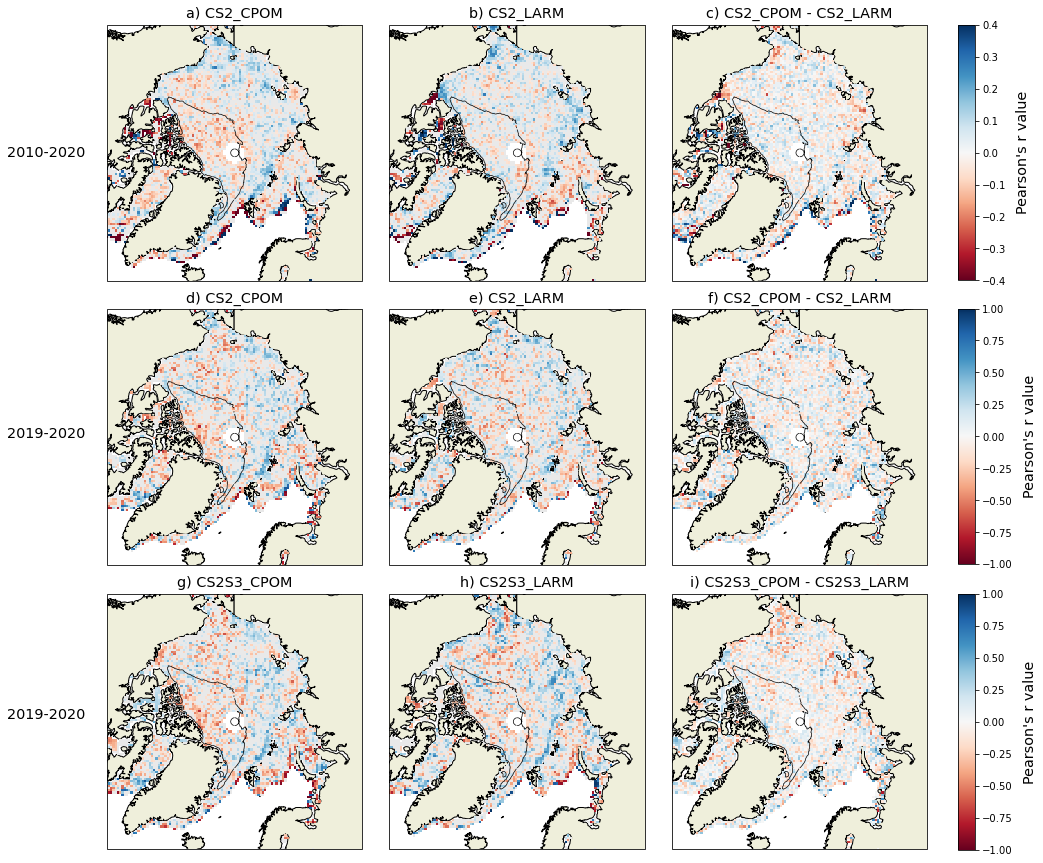

In [25]:
# Correlation between SM-LG and WG interpolated freeboards smoothed anomalies for 2019-2020 period

lats = np.load('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/Robbie_lat.npy')
lons = np.load('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/Robbie_lon.npy')

sats = ['CS2_CPOM_full','CS2_LARM_full','CS2_CPOM_full - CS2_LARM_full',
        'CS2_CPOM','CS2_LARM','CS2_CPOM - CS2_LARM',
        'CS2S3_CPOM','CS2S3_LARM','CS2S3_CPOM - CS2S3_LARM']
labels = ['CS2_CPOM','CS2_LARM','CS2_CPOM - CS2_LARM',
        'CS2_CPOM','CS2_LARM','CS2_CPOM - CS2_LARM',
        'CS2S3_CPOM','CS2S3_LARM','CS2S3_CPOM - CS2S3_LARM']
nums = ['a) ','b) ','c) ','d) ','e) ','f) ','g) ','h) ','i) ']

fig, axs = plt.subplots(3,3,figsize = (12,12),subplot_kw={'projection':ccrs.NorthPolarStereo()})
vmins = [-0.4, -0.4, -0.4, -1, -1, -1, -1, -1, -1]
vmaxs = [0.4, 0.4, 0.4, 1, 1, 1, 1, 1, 1]

for counter, ax in enumerate(axs.reshape(-1)):
    rs = all_rs[sats[counter]]
    ps = all_ps[sats[counter]]    

    rs[ps>0.05] = 1000
    grey = rs.copy()
    grey[grey <1000] = np.nan
    rs[rs==1000] = np.nan

    ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    p_map = ax.pcolormesh(lons,lats,rs,cmap='RdBu',vmin=vmins[counter],vmax=vmaxs[counter],alpha=1.0, transform=ccrs.PlateCarree())
    ax.pcolormesh(lons,lats,grey,cmap='Greys',vmin=0,vmax=6000,alpha=1.0, transform=ccrs.PlateCarree())
    ax.set_title(nums[counter]+labels[counter],fontsize='x-large', pad=7)
    
    cont_less = ax.contour(lon2d_lesser,
                  lat2d_lesser,
                  ice_type_lesser,
                  levels=[0.5],
                  transform=ccrs.PlateCarree(),
                  colors='k',
                  linewidths=0.7)

    cont_Great = ax.contour(lon2d_greater,
                  lat2d_greater,
                  ice_type_greater,
                  levels=[0.5],
                  transform=ccrs.PlateCarree(),
                  colors='k',
                  linewidths=0.7)
    
    if counter == 2: 
        cbar_ax = fig.add_axes([1.01, 0.671, 0.02, 0.296]) # x, y, width, height
        a = fig.colorbar(p_map, cax=cbar_ax)
        a.set_label("Pearson's r value", fontsize = 'x-large',labelpad = 10)
    if counter == 5: 
        cbar_ax = fig.add_axes([1.01, 0.3425, 0.02, 0.296])
        a = fig.colorbar(p_map, cax=cbar_ax)
        a.set_label("Pearson's r value", fontsize = 'x-large',labelpad = 10)
    if counter == 8: 
        cbar_ax = fig.add_axes([1.01, 0.012, 0.02, 0.296])
        a = fig.colorbar(p_map, cax=cbar_ax)
        a.set_label("Pearson's r value", fontsize = 'x-large',labelpad = 10)
plt.annotate('2010-2020',xy=(-55,2.7),va='bottom',ha='left',xycoords='axes fraction',color='k', fontsize = 'x-large')
plt.annotate('2019-2020',xy=(-55,1.6),va='bottom',ha='left',xycoords='axes fraction',color='k', fontsize = 'x-large')
plt.annotate('2019-2020',xy=(-55,0.5),va='bottom',ha='left',xycoords='axes fraction',color='k', fontsize = 'x-large')
fig.tight_layout()
plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/Snow Interpolated Freeboards/figures/retrack_gridcells.png',bbox_inches = "tight")

In [20]:
sats = ['CS2_CPOM','CS2_Bristol','CS2_S3_CPOM','CS2_S3_Bristol']

pos = {}
neg = {}

for sat in sats:
    rs_list = all_rs_list[sat]
    rs_array = np.asarray(rs_list)
    positive = (rs_array > 0).sum(axis = 0).astype(np.float32)
    pos[sat] = positive
    negative = (rs_array < 0).sum(axis = 0).astype(np.float32)
    neg[sat] = negative


# compare number of positive and negative grid cells

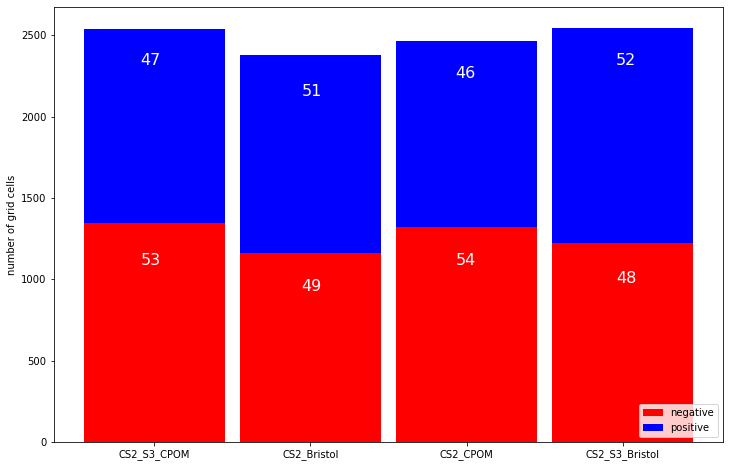

In [31]:
fig = plt.figure(figsize=(12,8))

sat = ['CS2_S3_CPOM','CS2_Bristol','CS2_CPOM','CS2_S3_Bristol']
negs = [neg['CS2_S3_CPOM'],neg['CS2_Bristol'],neg['CS2_CPOM'],neg['CS2_S3_Bristol']]
poss = [pos['CS2_S3_CPOM'],pos['CS2_Bristol'],pos['CS2_CPOM'],pos['CS2_S3_Bristol']]

w = 0.9

plt.bar(sat, negs, w, color='red', label = "negative")
plt.bar(sat, poss, w, bottom=negs, color='blue', label = "positive")

xs = [0.16,0.4,0.63,0.87]
ys_negs = [0.4, 0.34, 0.4, 0.36]
ys_poss = [0.86, 0.79, 0.83, 0.86]
counts = len(sat)

# for count in range(counts):
#     plt.annotate(round(negs[count]),xy=(xs[count],ys_negs[count]),va='bottom',ha='right',xycoords='axes fraction',color='white',fontsize=16) 
#     plt.annotate(round(poss[count]),xy=(xs[count],ys_poss[count]),va='bottom',ha='right',xycoords='axes fraction',color='white',fontsize=16) 
#     plt.annotate(round(poss[count]+negs[count]),xy=(xs[count],0.95),va='bottom',ha='right',xycoords='axes fraction',color='k',fontsize=16) 

for count in range(counts):
    neg_perc = (negs[count]/(poss[count]+negs[count]))*100
    pos_perc = (poss[count]/(poss[count]+negs[count]))*100
    plt.annotate(round(neg_perc),xy=(xs[count],ys_negs[count]),va='bottom',ha='right',xycoords='axes fraction',color='white',fontsize=16) 
    plt.annotate(round(pos_perc),xy=(xs[count],ys_poss[count]),va='bottom',ha='right',xycoords='axes fraction',color='white',fontsize=16) 

plt.ylabel("number of grid cells")
plt.legend(loc='lower right')
plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/AGU GRL Snow Interpolated Freeboards/figures/retrack_gridcells_perc.png',bbox_inches = "tight")

## only cells where FYI >75% of the time

In [25]:
threshp = 0.75
# pick a threshold for number of days to be FYI

total = len(days)
thresh = total * threshp

datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/icetype/'

icetype_grid = np.load(datapath+'icetype_'+'Oct2019_Apr2020_2019-2020.npy')

FYI_days = (icetype_grid == 2).sum(axis = 2).astype(np.float32)
MYI_days = (icetype_grid == 3).sum(axis = 2).astype(np.float32)
      
FYI_days[FYI_days < thresh] = np.nan  
FYI_days[~np.isnan(FYI_days)] = 1
MYI_days[MYI_days < thresh] = np.nan 
MYI_days[~np.isnan(MYI_days)] = 1

Grey areas are where p>0.05


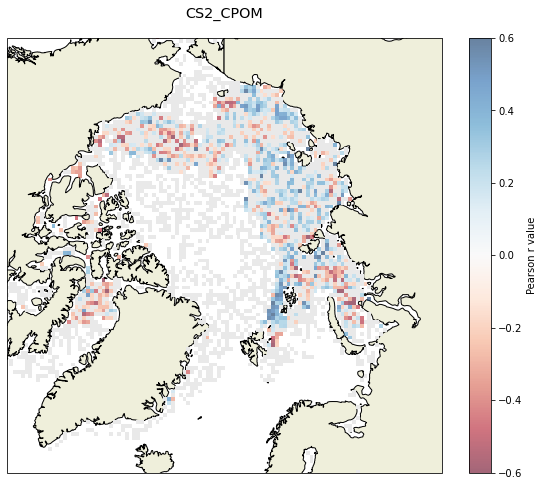

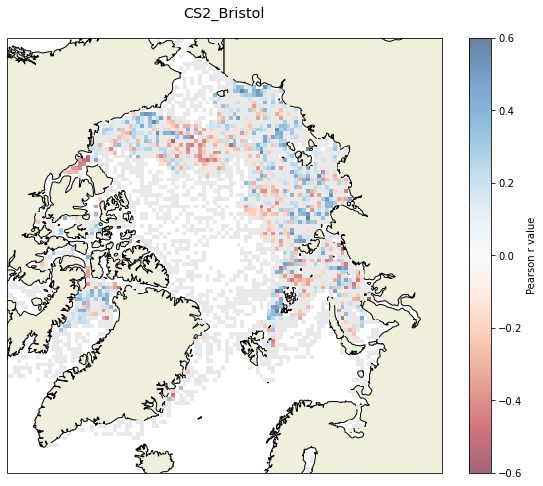

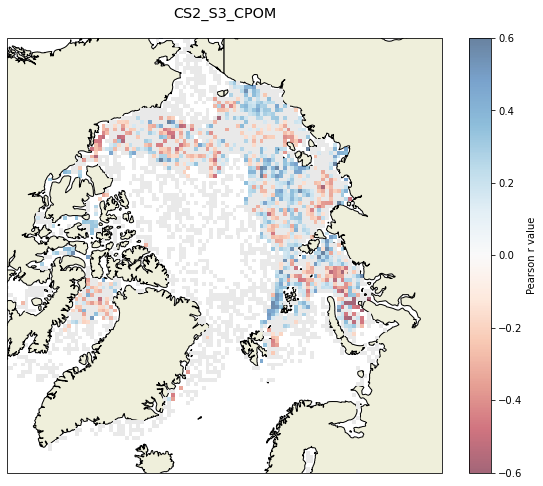

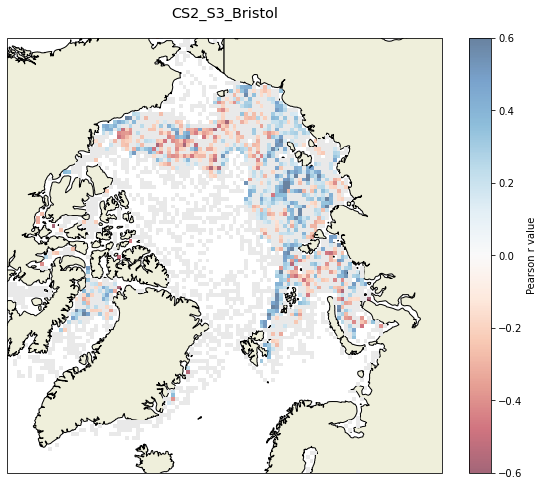

In [26]:
# Correlation between SM-LG and WG interpolated freeboards smoothed anomalies for 2019-2020 period over FYI

for sat in sats:
    rs = all_rs[sat]
    ps = all_ps[sat]

    rs_fyi = rs.copy()
    rs_fyi[np.isnan(FYI_days)] = np.nan
    
    rs[ps>0.05] = 1000
    grey = rs.copy()
    grey[grey <1000] = np.nan
    rs[rs==1000] = np.nan

    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    p_map = ax.pcolormesh(lons,lats,rs_fyi,cmap='RdBu',vmin=-0.6,vmax=0.6,alpha=0.6, transform=ccrs.PlateCarree())
    ax.pcolormesh(lons,lats,grey,cmap='Greys',vmin=0,vmax=6000,alpha=1.0, transform=ccrs.PlateCarree())
    a = fig.colorbar(p_map)
    a.set_label('Pearson r value')
    ax.set_title(sat,fontsize='x-large', pad=20)
print('Grey areas are where p>0.05')

## only cells where MYI >75% of the time

Grey areas are where p>0.05


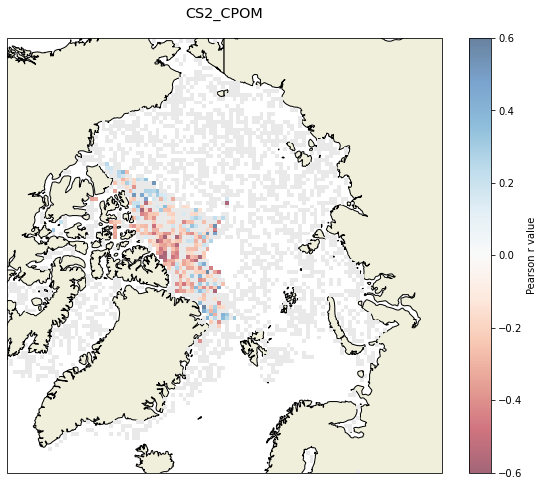

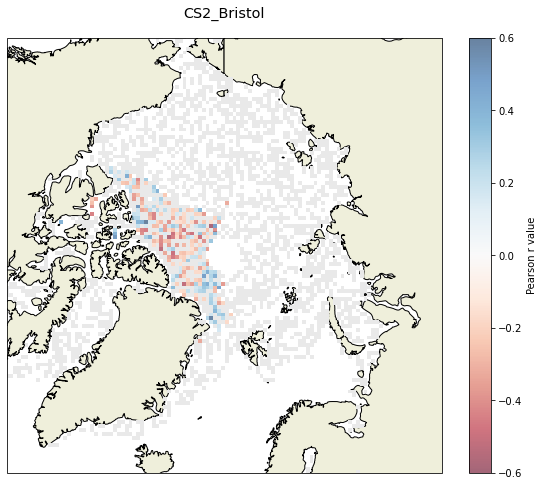

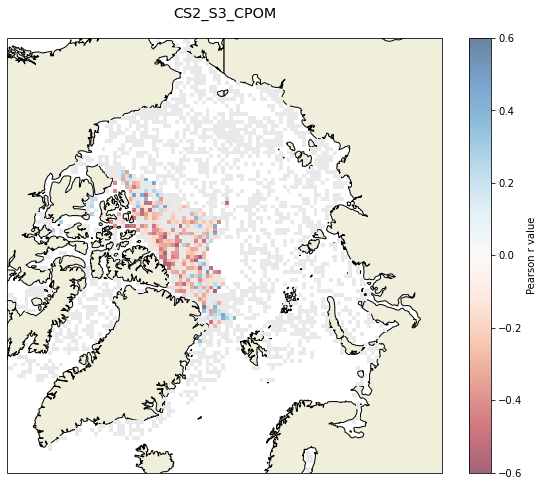

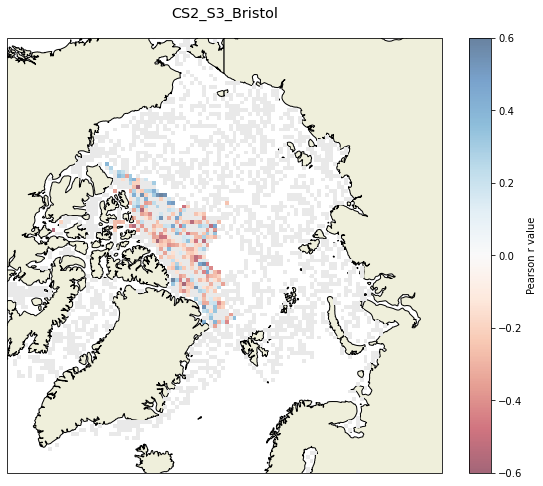

In [27]:
# Correlation between SM-LG and WG interpolated freeboards smoothed anomalies for 2019-2020 period over MYI

for sat in sats:
    rs = all_rs[sat]
    ps = all_ps[sat]
    
    rs_myi = rs.copy()
    rs_myi[np.isnan(MYI_days)] = np.nan
    
    rs[ps>0.05] = 1000
    grey = rs.copy()
    grey[grey <1000] = np.nan
    rs[rs==1000] = np.nan

    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    p_map = ax.pcolormesh(lons,lats,rs_myi,cmap='RdBu',vmin=-0.6,vmax=0.6,alpha=0.6, transform=ccrs.PlateCarree())
    ax.pcolormesh(lons,lats,grey,cmap='Greys',vmin=0,vmax=6000,alpha=1.0, transform=ccrs.PlateCarree())
    a = fig.colorbar(p_map)
    a.set_label('Pearson r value')
    ax.set_title(sat,fontsize='x-large', pad=20)
print('Grey areas are where p>0.05')

In [28]:
# to do:
    # do plot with mask out negative snow anomalies
    # do plot with first year of fb cut off and last year of snow cut off - shows random noise
    # mask for less than 500 valid cells
    # find out number of pixels with statistical significance